Calculating the mld depth using interpolation of the s-levels in the Norkyst dataset. This creates more continous depths and might make the mld calculations more accurate than using a transformation method from s_rho to z_rho. This notebook is to visualize the differences and compare these two methods of calculating the mld. I will use the xarray interpolation feature as recommended by a colleauge. Ill try using a linear method. If this interpolation lacks effiency, I might consider using xroms and sgrid instead, but I will try to stick with xarray.

In [2]:
from script_mld import dens
from script_mld import transformation
from script_mld import MLD
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

In [7]:
#we try (30.03.2024)
#TODO sjekk at det blir riktig datasett å jobbe med - eller om de ønsker at jeg skal bruke operational
ds_2024 = xr.open_dataset(f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240330.nc').isel(time = 0)
ds_2024.head()

<xarray.Dataset> Size: 4kB
Dimensions:           (Y: 5, X: 5, s_rho: 5, s_w: 5)
Coordinates:
    time              datetime64[ns] 8B 2024-03-30
  * s_rho             (s_rho) float64 40B -0.9799 -0.9403 ... -0.8634 -0.8261
  * X                 (X) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * Y                 (Y) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * s_w               (s_w) float64 40B -1.0 -0.96 -0.9208 -0.8823 -0.8446
    lon               (Y, X) float64 200B ...
    lat               (Y, X) float64 200B ...
Data variables: (12/18)
    Uwind_eastward    (Y, X) float32 100B ...
    Vwind_northward   (Y, X) float32 100B ...
    zeta              (Y, X) float32 100B ...
    ubar_eastward     (Y, X) float32 100B ...
    vbar_northward    (Y, X) float32 100B ...
    u_eastward        (s_rho, Y, X) float32 500B ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 40B ...
    Cs_w              (s_w) float64 40B ...
    h                 (Y, X) float32 100B ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      15f95603-12d1-4e0f-8cbe-33946594447f
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [14]:
ds_2024.salinity

<xarray.DataArray 'salinity' (s_rho: 40, Y: 1148, X: 2747)> Size: 505MB
[126142240 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2024-03-30
  * s_rho    (s_rho) float64 320B -0.9799 -0.9403 -0.9014 ... -0.01529 -0.004904
  * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
    lon      (Y, X) float64 25MB ...
    lat      (Y, X) float64 25MB ...
Attributes:
    grid:                   grid
    location:               face
    field:                  salinity, scalar, series
    grid_mapping:           projection_stere
    long_name:              Sea water salinity
    standard_name:          sea_water_salinity
    coverage_content_type:  modelResult
    units:                  1
    time:                   time

In [15]:
transformation(ds_2024)
z = ds_2024.z_rho
z

<xarray.DataArray 'z_rho' (s_rho: 40, X: 2747, Y: 1148)> Size: 1GB
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [-192.12333081, -192.08629577, -192.01893191, ...,
         -137.8629532 , -139.41269894, -140.22684758],
        [-192.19551293, -192.14912847, -192.06400226, ...,
         -134.46273268, -135.81615895, -136.51640733],
        [-192.20043684, -192.15014044, -192.05747733, ...,
         -132.64107428, -133.87078573, -134.49901642]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
           -1.46077985,   -1.46515363,   -1.46742996],
        [  -2.00569916,   -2.00560909,   -2.0054437 , ...,
           -1.45099178,   -1.45491988,   -1.4569355 ],
        [  -2.00570873,   -2.00561105,   -2.00543102, ...,
           -1.44563628,   -1.4492602 ,   -1.45109765]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [  -1.30441983,   -1.30439792,   -1.30435806, ...,
           -0.84605337,   -0.8474104 ,   -0.84811639],
        [  -1.30446251,   -1.30443509,   -1.30438473, ...,
           -0.84301403,   -0.84423416,   -0.84486004],
        [  -1.30446542,   -1.30443569,   -1.30438087, ...,
           -0.84134966,   -0.842476  ,   -0.84304692]]],
      shape=(40, 2747, 1148))
Coordinates:
    time     datetime64[ns] 8B 2024-03-30
  * s_rho    (s_rho) float64 320B -0.9799 -0.9403 -0.9014 ... -0.01529 -0.004904
  * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
    lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
    lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73
    z_rho    (s_rho, X, Y) float64 1GB nan nan nan ... -0.8413 -0.8425 -0.843

In [16]:
#hente ut temp også
temp = ds_2024.temperature
salinity = ds_2024.salinity
#og hente ut dimensjoner, så først sjekke datsettet og dimensjonene 
ds_2024

<xarray.Dataset> Size: 4GB
Dimensions:           (Y: 1148, X: 2747, s_rho: 40, s_w: 41)
Coordinates:
    time              datetime64[ns] 8B 2024-03-30
  * s_rho             (s_rho) float64 320B -0.9799 -0.9403 ... -0.004904
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * s_w               (s_w) float64 328B -1.0 -0.96 -0.9208 ... -0.01 0.0
    lon               (X, Y) float64 25MB 8.7 8.69 8.679 ... 18.38 18.35 18.33
    lat               (X, Y) float64 25MB 54.29 54.3 54.3 ... 75.72 75.72 75.73
    z_rho             (s_rho, X, Y) float64 1GB nan nan nan ... -0.8425 -0.843
Data variables: (12/18)
    Uwind_eastward    (Y, X) float32 13MB ...
    Vwind_northward   (Y, X) float32 13MB ...
    zeta              (Y, X) float32 13MB ...
    ubar_eastward     (Y, X) float32 13MB ...
    vbar_northward    (Y, X) float32 13MB ...
    u_eastward        (s_rho, Y, X) float32 505MB ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 320B ...
    Cs_w              (s_w) float64 328B ...
    h                 (Y, X) float32 13MB ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      15f95603-12d1-4e0f-8cbe-33946594447f
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [17]:
#dims
Nx = temp.shape[2]
Ny = temp.shape[1]
Nt = temp.shape[0]
Nz = ds_2024.s_w.shape[0]

#new depth to interpolate to 
new_depth = np.linspace(z.min().item(), z.max().item(), 200)
new_depth[-1] = z.max().item()

In [18]:
#try Victors code
#just testing some things to make sure I understand the logistics of the code:

In [19]:
array = np.array([3,np.nan])

In [20]:
mask = np.isfinite(array)

In [21]:
print(mask)
new_depth = np.linspace(0, 2000, 200)

[ True False]


In [22]:
if mask.sum() < 2:
    test = np.full_like(new_depth, np.nan)
    print(f'The sum is less than two, the sum is: {mask.sum()}')
    print(f'New depth now consists of: {test}')
else:
    print(mask.sum())


The sum is less than two, the sum is: 1
New depth now consists of: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


In [23]:
#Okay so he interpolates as long as the existing depth array consists of minimum two finite points
#this is because two real points is necessary to be able to perform the interpolation
#I understand the code for a single point, will adapt the one for the whole grid:

In [24]:
import time

In [25]:
start = time.time()

#we need to add salinity!!!!
def interpolate_grid(depth_transf, Temp, Salinity, nz = 40, eta_chunck = 40):

    #create grid sizes
    eta_size = depth_transf.sizes['Y']
    xi_size = depth_transf.sizes['X']

    #initialize array
    out_array = np.full((3, nz, eta_size, xi_size), np.nan) #np.full(shape, fill_val)
    
    print(f'The original shape of depth transformed is: {depth_transf.shape}')
    print(f'The original shape of temp is: {Temp.shape}')
    print(f'The original shape of salnity is: {Salinity.shape}')
    
    #Horizontal slice
    for i_start in range(0,eta_size, eta_chunck):
        i_end = min(i_start+eta_chunck, eta_size) #ends at 1148

        depth_slice = depth_transf[:, i_start:i_end, :].values
        temp_slice = Temp[:, i_start:i_end, :].values
        salinity_slice = Salinity[:, i_start:i_end, :].values

        print(f'Depth slice {depth_slice.shape}')
        print(f'Temp slice {temp_slice.shape}')
        print(f'Salinity slice {salinity_slice.shape}')

        #vectorized interpolation

        for ii in range(depth_slice.shape[1]):  # eta in chunk
            for jj in range(depth_slice.shape[2]):  # xi
                dcol = depth_slice[:, ii, jj]
                tcol = temp_slice[:, ii, jj]
                scol = salinity_slice[:,ii,jj]
                
                mask = np.isfinite(dcol) & np.isfinite(tcol) & np.isfinite(scol)
                if mask.sum() < 2:
                    continue
                
                d = dcol[mask]
                t = tcol[mask]
                s = scol[mask]
                
                # Sort and remove duplicates
                sort_idx = np.argsort(d)
                d, t, s = d[sort_idx], t[sort_idx], s[sort_idx]
                keep = np.ones(len(d), bool)
                for k in range(1, len(d)):
                    if d[k] == d[k-1]:
                        keep[k] = False
                d, t, s = d[keep], t[keep], s[keep]

                
                # Column-specific new depth
                new_depth_col = np.linspace(d.min(), d.max(), nz)
                
                # Vectorized interpolation
                out_array[0, :, i_start+ii, jj] = np.interp(new_depth_col, d, t)
                out_array[1, :, i_start+ii, jj] = np.interp(new_depth_col, d, s)
                out_array[2, :, i_start+ii, jj] = new_depth_col
    
    #debugging
    print(f'Shape of d is: {d.shape}')
    print(f'Shape of t is: {t.shape}')
    print(f'Shape of s is: {s.shape}')

    da = xr.DataArray(out_array,
                      dims=("var", "new_depth", "eta_rho", "xi_rho"),
                      coords={"var": ["temperature", "salinity" ,"depth"]})
    
    return da

end = time.time()
print(f'Time elapsed is: {end - start:.2f} seconds')

Time elapsed is: 0.00 seconds


In [26]:
depth_transp = z.transpose(*temp.dims)

In [27]:
temp_da = interpolate_grid(depth_transp, temp, salinity, nz = 40)

The original shape of depth transformed is: (40, 1148, 2747)
The original shape of temp is: (40, 1148, 2747)
The original shape of salnity is: (40, 1148, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slice (40, 40, 2747)
Temp slice (40, 40, 2747)
Salinity slice (40, 40, 2747)
Depth slic

In [28]:
temp_da

<xarray.DataArray (var: 3, new_depth: 40, eta_rho: 1148, xi_rho: 2747)> Size: 3GB
array([[[[          nan,           nan,           nan, ...,
             2.08699942,    2.0449996 ,    2.04299974],
         [          nan,           nan,           nan, ...,
             2.1069994 ,    2.05699968,    2.03999949],
         [          nan,           nan,           nan, ...,
             2.13099957,    2.0909996 ,    2.06299973],
         ...,
         [          nan,           nan,           nan, ...,
             2.62999964,    2.65199947,    2.68799973],
         [          nan,           nan,           nan, ...,
             2.6619997 ,    2.68299961,    2.71699953],
         [          nan,           nan,           nan, ...,
             2.71099949,    2.72899961,    2.72299957]],

        [[          nan,           nan,           nan, ...,
             2.08699942,    2.01172424,    2.02553019],
         [          nan,           nan,           nan, ...,
             2.1069994 ,    2.05284027,    2.03833588],
         [          nan,           nan,           nan, ...,
             2.13099957,    2.0909996 ,    2.06383149],
...
            -4.35930721,   -4.26916066,   -4.22082978],
         [          nan,           nan,           nan, ...,
            -4.40036651,   -4.30505275,   -4.2534583 ],
         [          nan,           nan,           nan, ...,
            -4.42193001,   -4.32361767,   -4.27012306]],

        [[          nan,           nan,           nan, ...,
            -1.30441983,   -1.30446251,   -1.30446542],
         [          nan,           nan,           nan, ...,
            -1.30439792,   -1.30443509,   -1.30443569],
         [          nan,           nan,           nan, ...,
            -1.30435806,   -1.30438473,   -1.30438087],
         ...,
         [          nan,           nan,           nan, ...,
            -0.84605337,   -0.84301403,   -0.84134966],
         [          nan,           nan,           nan, ...,
            -0.8474104 ,   -0.84423416,   -0.842476  ],
         [          nan,           nan,           nan, ...,
            -0.84811639,   -0.84486004,   -0.84304692]]]],
      shape=(3, 40, 1148, 2747))
Coordinates:
  * var      (var) <U11 132B 'temperature' 'salinity' 'depth'
Dimensions without coordinates: new_depth, eta_rho, xi_rho

In [90]:
print(temp_da[1])
temp_da[1,:,1147,2111].values

<xarray.DataArray (new_depth: 40, eta_rho: 1148, xi_rho: 2747)> Size: 1GB
array([[[        nan,         nan,         nan, ..., 34.38000107,
         34.38999939, 34.39199829],
        [        nan,         nan,         nan, ..., 34.37799835,
         34.38700104, 34.39300156],
        [        nan,         nan,         nan, ..., 34.37200165,
         34.38000107, 34.38199997],
        ...,
        [        nan,         nan,         nan, ..., 34.71800232,
         34.72100067, 34.72499847],
        [        nan,         nan,         nan, ..., 34.72000122,
         34.72200012, 34.72499847],
        [        nan,         nan,         nan, ..., 34.72299957,
         34.72600174, 34.72499847]],

       [[        nan,         nan,         nan, ..., 34.38332665,
         34.39166225, 34.39532718],
        [        nan,         nan,         nan, ..., 34.37799835,
         34.38700104, 34.39799317],
        [        nan,         nan,         nan, ..., 34.37200165,
         34.38000107, 34.3836

array([34.91300201, 34.91300201, 34.91300201, 34.91300201, 34.91300201,
       34.91272959, 34.9122832 , 34.91199875, 34.91199875, 34.91199875,
       34.91167065, 34.91129114, 34.91091256, 34.91053702, 34.91016149,
       34.90978096, 34.90939667, 34.90901237, 34.90860912, 34.90820525,
       34.90821513, 34.90864858, 34.90908949, 34.90956247, 34.91015743,
       34.91225085, 34.91409708, 34.91468094, 34.91410877, 34.9121349 ,
       34.91685033, 34.92696253, 34.95583531, 35.00569407, 35.04168179,
       35.05493859, 35.05500031, 35.05500031, 35.05500031, 35.05599976])

In [96]:
salinity

<xarray.DataArray 'salinity' (s_rho: 40, Y: 1148, X: 2747)> Size: 505MB
array([[[      nan,       nan, ..., 34.39    , 34.392   ],
        [      nan,       nan, ..., 34.387   , 34.393   ],
        ...,
        [      nan,       nan, ..., 34.722   , 34.725   ],
        [      nan,       nan, ..., 34.726   , 34.725   ]],

       [[      nan,       nan, ..., 34.392   , 34.396   ],
        [      nan,       nan, ..., 34.387   , 34.399002],
        ...,
        [      nan,       nan, ..., 34.722   , 34.725   ],
        [      nan,       nan, ..., 34.726   , 34.726   ]],

       ...,

       [[      nan,       nan, ..., 34.357002, 34.357002],
        [      nan,       nan, ..., 34.357002, 34.358   ],
        ...,
        [      nan,       nan, ..., 34.289   , 34.28    ],
        [      nan,       nan, ..., 34.282   , 34.281   ]],

       [[      nan,       nan, ..., 34.357002, 34.357002],
        [      nan,       nan, ..., 34.358   , 34.358   ],
        ...,
        [      nan,       nan, ..., 34.289   , 34.28    ],
        [      nan,       nan, ..., 34.282   , 34.281   ]]],
      shape=(40, 1148, 2747), dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2024-03-30
  * s_rho    (s_rho) float64 320B -0.9799 -0.9403 -0.9014 ... -0.01529 -0.004904
  * X        (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y        (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.16e+05 9.168e+05 9.176e+05
    lon      (X, Y) float64 25MB 8.7 8.69 8.679 8.669 ... 18.4 18.38 18.35 18.33
    lat      (X, Y) float64 25MB 54.29 54.3 54.3 54.3 ... 75.72 75.72 75.73
    z_rho    (s_rho, X, Y) float64 1GB nan nan nan ... -0.8413 -0.8425 -0.843
Attributes:
    grid:                   grid
    location:               face
    field:                  salinity, scalar, series
    grid_mapping:           projection_stere
    long_name:              Sea water salinity
    standard_name:          sea_water_salinity
    coverage_content_type:  modelResult
    units:                  1
    time:                   time

[[[      nan       nan       nan ... 34.38     34.39     34.392   ]
  [      nan       nan       nan ... 34.378    34.387    34.393   ]
  [      nan       nan       nan ... 34.372    34.38     34.382   ]
  ...
  [      nan       nan       nan ... 34.718002 34.721    34.725   ]
  [      nan       nan       nan ... 34.72     34.722    34.725   ]
  [      nan       nan       nan ... 34.723    34.726    34.725   ]]

 [[      nan       nan       nan ... 34.384    34.392    34.396   ]
  [      nan       nan       nan ... 34.378    34.387    34.399002]
  [      nan       nan       nan ... 34.372    34.38     34.384   ]
  ...
  [      nan       nan       nan ... 34.718002 34.721    34.725   ]
  [      nan       nan       nan ... 34.72     34.722    34.725   ]
  [      nan       nan       nan ... 34.723    34.726    34.726   ]]

 [[      nan       nan       nan ... 34.387    34.392    34.398   ]
  [      nan       nan       nan ... 34.379    34.387    34.403   ]
  [      nan       nan       nan

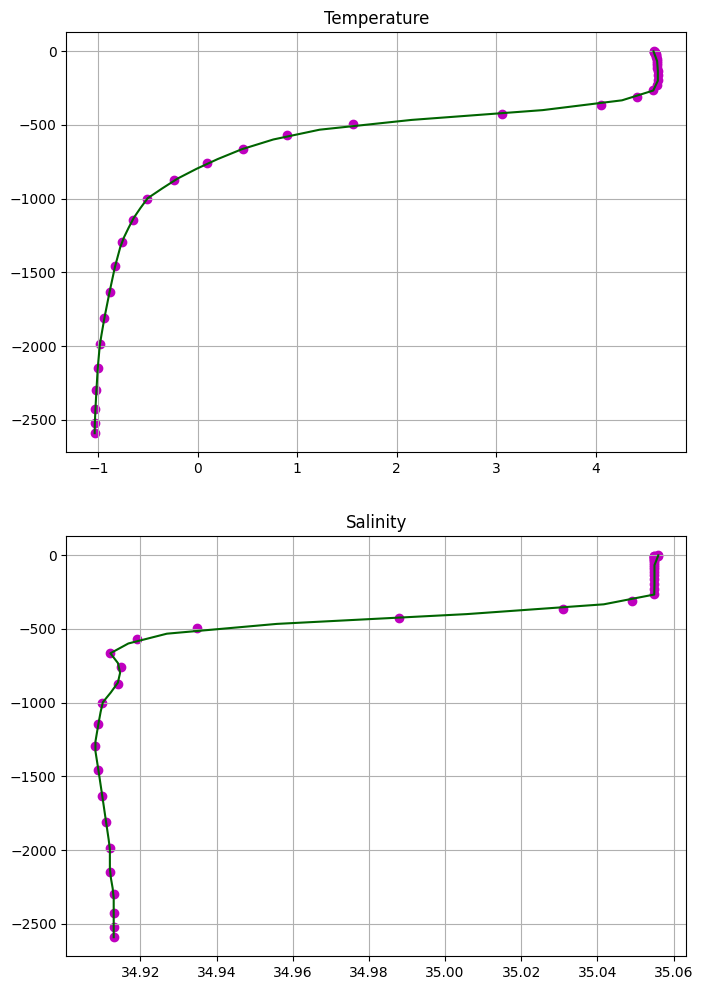

In [102]:
#selecting out one point
X, Y = 1147,2111
depth_orig = z[:,Y,X]
temp_orig = temp[:,X,Y]
print(salinity.values)
salinity_orig = salinity[:,X,Y]

print(f'Original salinity values are: {salinity_orig.values}')

#print(f'The values of the interpolated temperature is: {temp_da[0,:,X,Y]}')
#print(f'The values of the interpolated temperature is: {temp_da[1,:,X,Y]}')

#the interpolation works as it should
fig, ax = plt.subplots(2, figsize = (8,12))
ax[0].scatter(temp_orig, depth_orig, color = 'm', label = 'Original')
ax[0].plot(temp_da[0,:,X,Y].values, temp_da[2, :, X, Y].values, label = 'Interpolated', color = 'darkgreen', zorder = 20)
ax[1].scatter(salinity_orig, depth_orig, color = 'm', label = 'Original')
ax[1].plot(temp_da[1,:,X,Y].values, temp_da[2, :, X, Y].values, color = 'darkgreen', label = 'Interpolated')
ax[0].set_title('Temperature')
ax[1].set_title('Salinity')
ax[0].grid(True)
ax[1].grid(True)

In [ ]:
#Now that it works as it should, we want to exctract the temperature and salinity for calculating the pot dens and the mld 
temp_int = temp_da[0, :, X, Y].values 
salinity_int = temp_da[1, :, X, Y].values

print(salinity_int)

#error in calculating the pot dens, check for infinite values
mask_nan = np.isfinite(temp_int)
print(mask_nan)

#now it suddenly works
pot_dens = dens(temp_int, salinity_int)

[34.91300201 34.91300201 34.91300201 34.91300201 34.91300201 34.91272959
 34.9122832  34.91199875 34.91199875 34.91199875 34.91167065 34.91129114
 34.91091256 34.91053702 34.91016149 34.90978096 34.90939667 34.90901237
 34.90860912 34.90820525 34.90821513 34.90864858 34.90908949 34.90956247
 34.91015743 34.91225085 34.91409708 34.91468094 34.91410877 34.9121349
 34.91685033 34.92696253 34.95583531 35.00569407 35.04168179 35.05493859
 35.05500031 35.05500031 35.05500031 35.05599976]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [116]:
pot_dens

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
       994.21468273, 994.39502218, 994.62943077, 994.97169599,
       995.64760923, 996.60484921, 997.18132621, 997.40857228,
       997.44279966, 997.44273427, 997.43734665, 997.4102183 ])

In [118]:
MLD(pot_dens, temp_da[2,:, X,Y].values) #pot dens and depth

The first depth where the treshold is exceeded is: -200.19127617695494


In [103]:
#Super so now we have to make a code where we can store the pot_dens and mld based on the interpolated depth rather than the transformed depth

# Storing the results:

1. Define the Norkyst dataset
2. Use z_rho transform using your already existing code (from the 2m depth project)
3. Using z_rho, we interpolate the depth using temperature (do I have to interpolate for salinity as well tru?) and return it as a new dataarray
4. Using this interpolated depth, we can calculate the potenial density and the mld to store in a new dataset or add it to the exisiting one. Maybe create a new one for simplicity. 


- OBS!! One plot per season, so maybe average for three months at a time? using rolling mean for example

In [ ]:
#import functions
from calc_mld import interpolate_grid, transformation
from script_mld import MLD, dens

In [ ]:
def prepare_dataset(ds):

    #Assumes that the dataset is already preprocessed based on the information you want, but I will need to add some type of mean I think for memory
    #Eg seasonal averages or yearly means in my case
    #Perform transformation and add them to the dataset
    transformation(ds)

    #select out the new variable
    z = ds['z_rho']

    #then we interpolate
    #Gather the needed variables
    temp = ds['temperature']
    salinity = ds['salinity']
    #transpose depth to ensure the dimensions match
    depth_transposed = z.transpose(*temp.dims)
    da = interpolate_grid(depth_transposed, temp, salinity, nz = 40)

    return da 

In [4]:
#Can not run here due to mem error
da = prepare_dataset('/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240330.nc')

MemoryError: Unable to allocate 22.6 GiB for an array with shape (24, 1148, 2747, 40) and data type float64

In [ ]:
def calculate_store_mld(ds, filename):
    #DS is the one thats been run through prepare_dataset
    #select variables
    temp_interpolated = ds[0].values
    salinity_interpolated = ds[1].values
    depth_interpolated = ds[2].values

    #Initialize empty arrays
    tmpd = np.full((temp_interpolated.shape), np.nan)
    tmmld = np.full((temp_interpolated.shape[1], temp_interpolated.shape[2]), np.nan)

    for ii in range(temp_interpolated.shape[1]):
        for jj in range(temp_interpolated.shape[2]):
            #Collect all vertical depths
            temp_profile = temp_interpolated[:, ii, jj]
            salinity_profile = salinity_interpolated[:, ii, jj] 

            #make sure no infinite values are included 
            mask = np.isfinite(temp_profile) & np.isfinite(salinity_profile) & np.isfinite(depth_interpolated)
            temp = temp_profile[mask]
            salinity = salinity_profile[mask]
            depth = depth_interpolated[mask]

            if len(temp) < 2:
                continue

            potential_dens = dens(salinity, temp)
            tmpd[:, ii, jj] = potential_dens

            mixed_layer = MLD(potential_dens, depth)
            tmmld[ii, jj] = mixed_layer

    ds_mld = xr.Dataset(
        data_vars=dict(
            pd = (['new_depth', 'Y', 'X'], tmpd, {'Units' : 'kg m^{-3}', 'Name' : 'Potential Density', 'Description' : 'Potential density'}),
            Mixed_layer = (['X', 'Y'], tmmld, {'Units' : 'm', 'Name' : 'Mixed Layer depth', 'Description' : 'Mixed layer depth calculated from surface density and 0.03 kgm-3 treshold'})
        ),
        coords=dict(
            Depth = ds.coords['new_depth'].values,
            eta_rho = ds.coords['eta_rho'].values, #X
            xi_rho = ds.coords['xi_rho'].values,   #Y         
        )
    )

    #Convert to netcdf file for easy access to plot and use values
    ds_mld.to_netcdf(f'potential_dens_mld_{filename}.nc')

In [32]:
#now lets try to weigh the dataset to create seasonal averages 
#first import the dataset (again)

ds = xr.open_dataset(f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240330.nc').isel(time = 0)
ds


<xarray.Dataset> Size: 3GB
Dimensions:           (Y: 1148, X: 2747, s_rho: 40, s_w: 41)
Coordinates:
    time              datetime64[ns] 8B 2024-03-30
  * s_rho             (s_rho) float64 320B -0.9799 -0.9403 ... -0.004904
  * X                 (X) float64 22kB 0.0 800.0 1.6e+03 ... 2.196e+06 2.197e+06
  * Y                 (Y) float64 9kB 0.0 800.0 1.6e+03 ... 9.168e+05 9.176e+05
  * s_w               (s_w) float64 328B -1.0 -0.96 -0.9208 ... -0.01 0.0
    lon               (Y, X) float64 25MB ...
    lat               (Y, X) float64 25MB ...
Data variables: (12/18)
    Uwind_eastward    (Y, X) float32 13MB ...
    Vwind_northward   (Y, X) float32 13MB ...
    zeta              (Y, X) float32 13MB ...
    ubar_eastward     (Y, X) float32 13MB ...
    vbar_northward    (Y, X) float32 13MB ...
    u_eastward        (s_rho, Y, X) float32 505MB ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 320B ...
    Cs_w              (s_w) float64 328B ...
    h                 (Y, X) float32 13MB ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      15f95603-12d1-4e0f-8cbe-33946594447f
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [ ]:
month_length = ds.time.dt
month_length

weights = ()